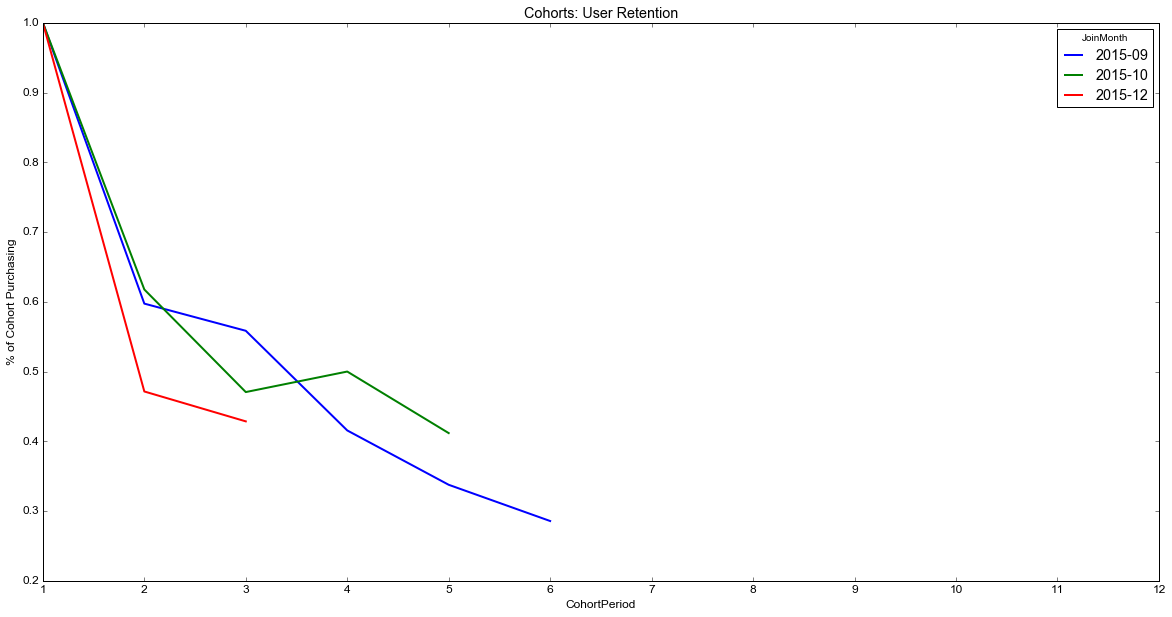

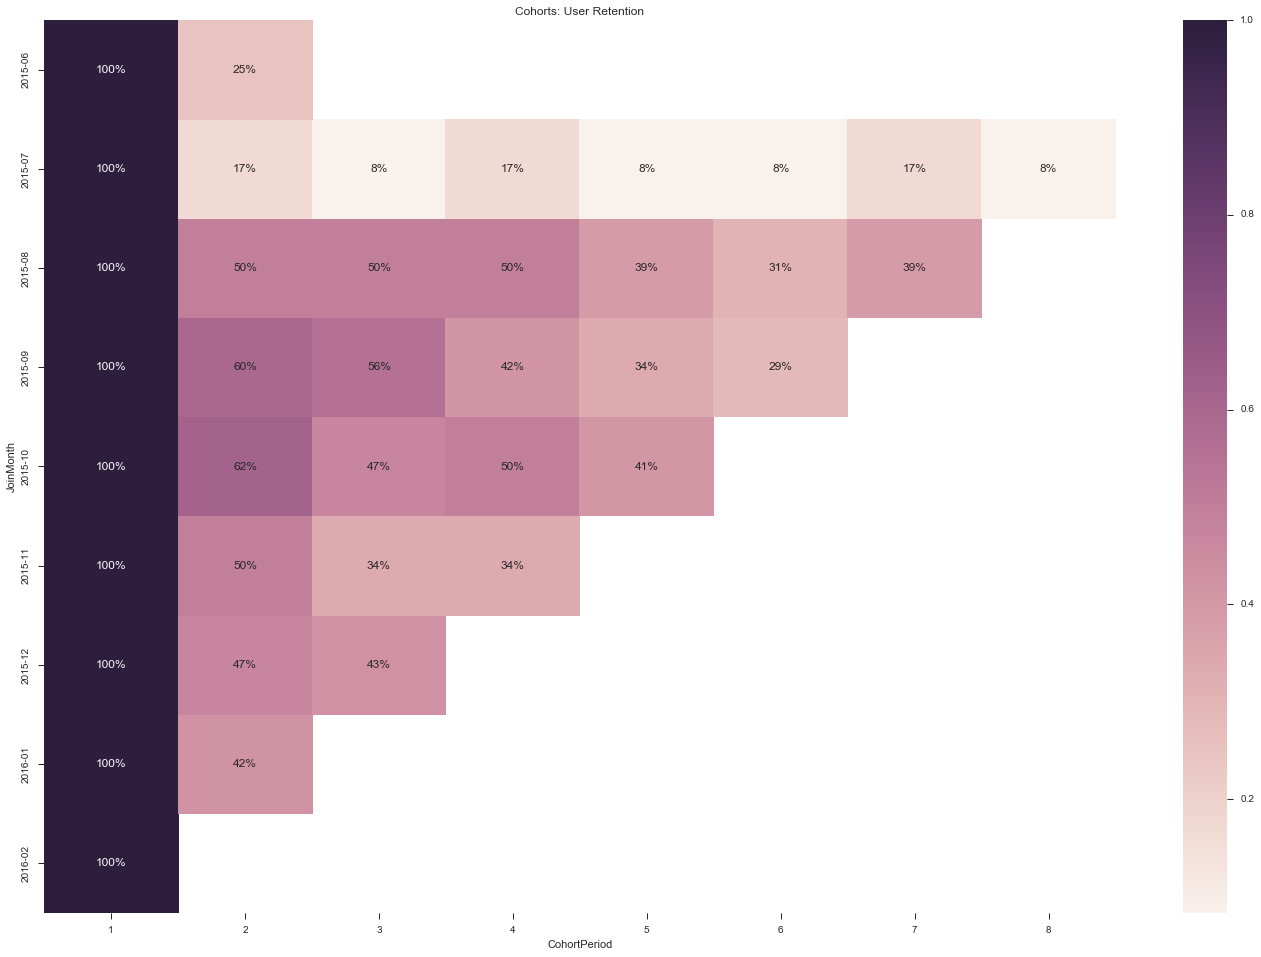

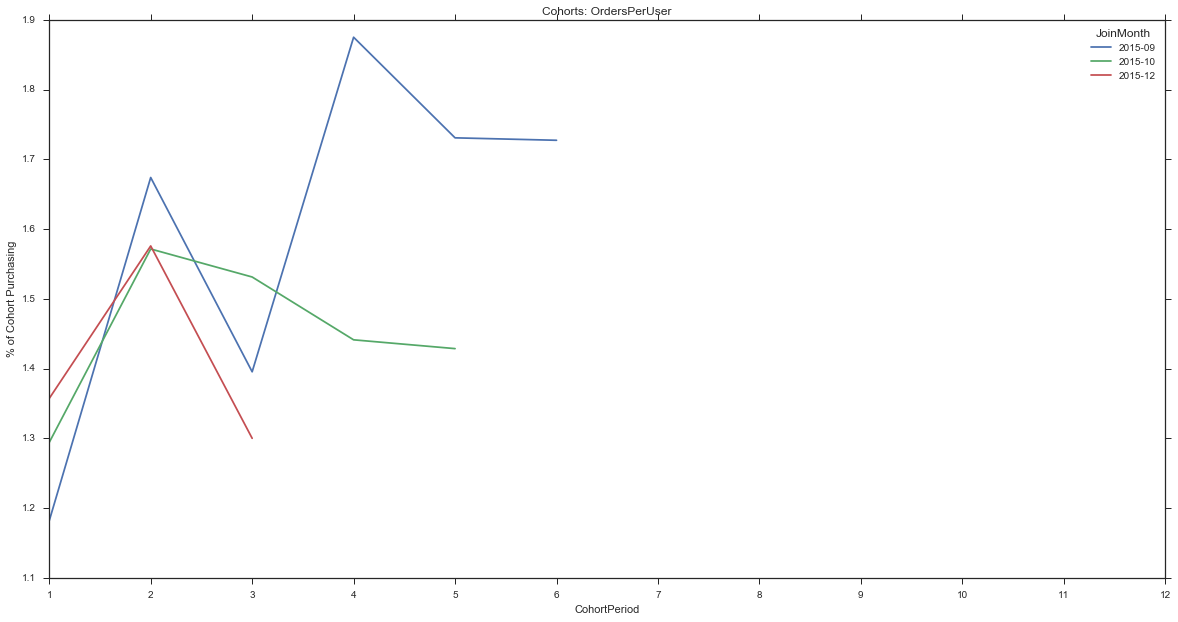

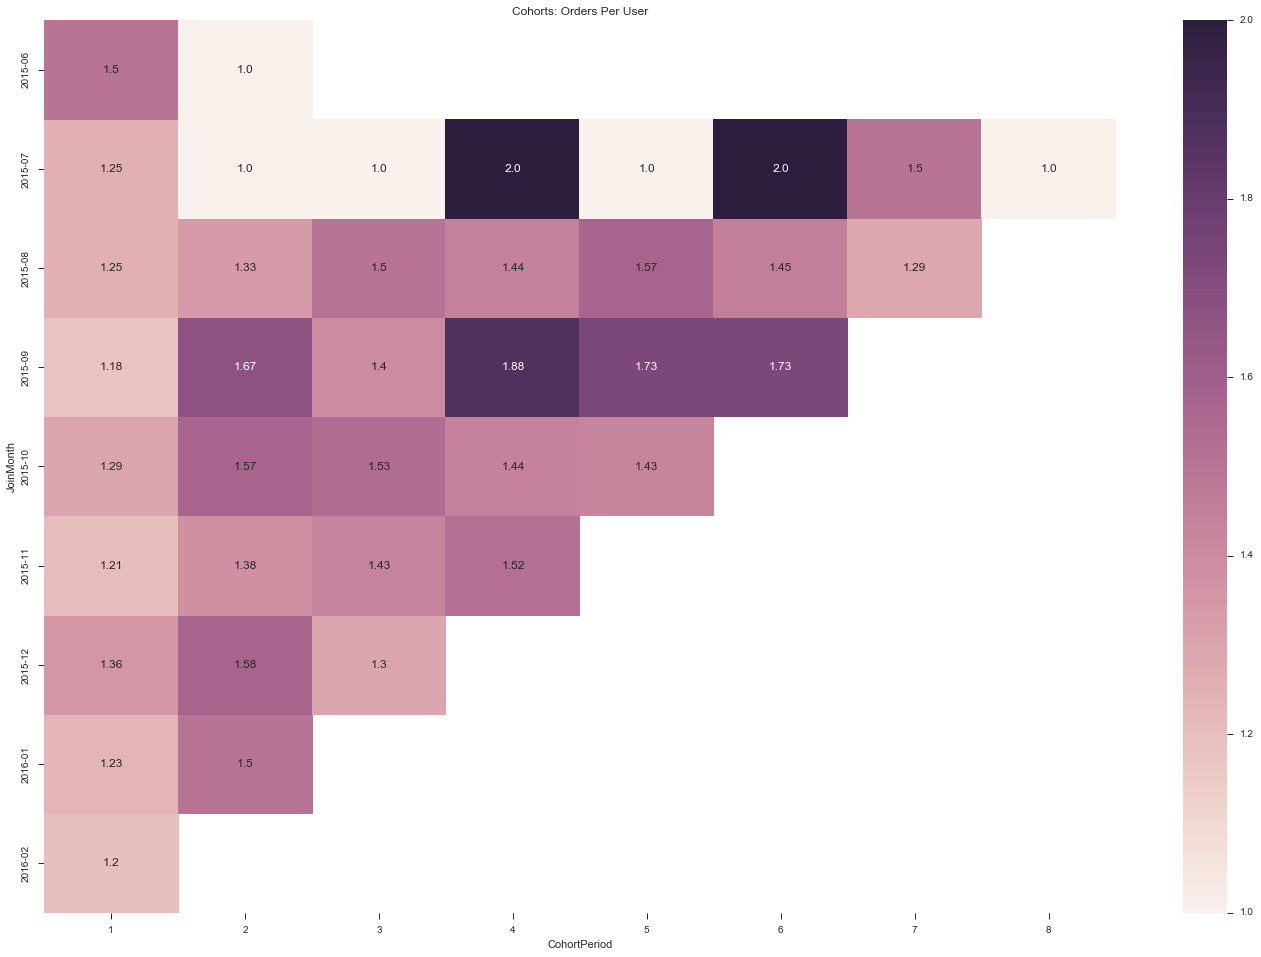

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

# это чтобы графики строились непосредственно в блокноте iPython
%matplotlib inline 

df = pd.read_excel('vo.xlsx')
# Добавим столбец OrderPeriod для дальнейшей группировки данных
df['OrderPeriod'] = df.orderDTE.apply(lambda x: x.strftime('%Y-%m'))
df.set_index('ClientID', inplace=True) #добавим индекс в dataFrame по ClientID

df['JoinMonth'] = df.groupby(level=0)['orderDTE'].min().apply(lambda x: x.strftime('%Y-%m')) #добавим столбец JoinMonth
df.reset_index(inplace=True) #переиндексируем df

df.insert(len(df.columns), "TotalOrders", 0, allow_duplicates=False) #создадим столбец в котором далее поместим количество заказов

#свернем данные в когорты
grouped = df.groupby(['JoinMonth', 'OrderPeriod'])

# количество уникальных пользователей и общее количество заказов и выручка за период
cohorts = grouped.agg({'ClientID': pd.Series.nunique,
                       'TotalOrders': pd.Series.count, 
                       'Revenue': np.sum})

# переименуем некоторые столбцы для большего понимания
cohorts.rename(columns={'ClientID': 'TotalUsers',
                        'TotalOrders': 'TotalOrders'}, inplace=True)

# добавим ярлык для периодов
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)

#посчитаем retention

# переиндексируем DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['JoinMonth','CohortPeriod'], inplace=True)

# создадим ряд содержаший размер каждой когорты JoinMonth
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohorts['TotalUsers'].unstack(0)
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)

user_retention[['2015-09', '2015-10', '2015-12']].plot(figsize=(20,10))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1)) # разбивка оси X
plt.xlim(1, 12) #ось X
plt.ylabel('% of Cohort Purchasing');

import seaborn as sns
sns.set(style='ticks')
plt.figure(figsize=(24, 16))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.00%');




## Расчитаем частоту покупок по когортам
c = cohorts['TotalOrders']/cohorts['TotalUsers']
opc = c.unstack(0)

opc[['2015-09', '2015-10', '2015-12']].plot(figsize=(20,10))
plt.title('Cohorts: OrdersPerUser')
plt.xticks(np.arange(1, 12.1, 1)) # разбивка оси X
plt.xlim(1, 12) #ось X
plt.ylabel('% of Cohort Purchasing');

#cohortsOPC = cohorts['TotalOrders']/cohorts['TotalUsers']

import seaborn as sns
sns.set(style='ticks')
plt.figure(figsize=(24, 16))
plt.title('Cohorts: Orders Per User')
sns.heatmap(opc.T, mask=opc.T.isnull(), annot=True, fmt='.3');